# Loading




In [ ]:
# Import useful libraries
import pandas as pd
import json
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, normalize, StandardScaler

In [ ]:
# Import Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# returns JSON object as a dictionary
f = open('/content/drive/MyDrive/Iceberg/train.json',) # The train.json file needs to be in an "Iceberg" directory

# creating a dataframe
df_raw = pd.DataFrame(json.load(f))

# visualising the first rows
df_raw.head()

,id,band_1,band_2,inc_angle,is_iceberg
0,dfd5f913,"[-27.878361, -27.15416, -28.668615, -29.537971...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
1,e25388fd,"[-12.242375, -14.920305, -14.920363, -12.66633...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
2,58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
3,4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
4,271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0


In [ ]:
# Visualising info
print(df_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1604 entries, 0 to 1603
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          1604 non-null   object
 1   band_1      1604 non-null   object
 2   band_2      1604 non-null   object
 3   inc_angle   1604 non-null   object
 4   is_iceberg  1604 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 62.8+ KB
None


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.metrics import precision_recall_curve

def show_bands(row):
  print(f'Index : {row.name}')
  f, (img1, img2) = plt.subplots(1, 2, figsize = (10,10))
  img1.imshow(np.array(row.band_1).reshape(75,75))
  img1.set_title("band_1")
  img2.imshow(np.array(row.band_2).reshape(75,75))
  img2.set_title("band_2")
  img1.set_yticks([])
  img1.set_xticks([])
  img2.set_yticks([])
  img2.set_xticks([])
  plt.show()

class EvaluateAndReport:
  def __init__(self, df, X_train, X_test, y_train, y_test, scoring = 'f1', grid_cv = 5, cv_cv = 10, threshold = 0.5):
    self.df = df
    self.X_train, self.y_train, self.X_test, self.y_test = X_train, y_train, X_test, y_test
    self.scoring = scoring
    self.grid_cv = grid_cv
    self.cv_cv = cv_cv
    self.threshold = threshold


  def grid_report(self, classifier = None, param_grid = None):
    if classifier is None:
      classifier = self.last_best
    if not(param_grid is None):
      print('--- Grid Search Report ---')
      grid_search = GridSearchCV(classifier, param_grid, cv = self.grid_cv, scoring = self.scoring, return_train_score = True)
      grid_search.fit(self.X_train, self.y_train)

      print(f'Best parameters for {classifier} :\n {grid_search.best_params_} with {self.scoring} score {round(grid_search.best_score_,3)}')

      self.last_best = grid_search.best_estimator_
    else:
      print("cross_report should be used when there is no param_grid")


  def cross_report(self, classifier = None):
    if classifier is None:
      classifier = self.last_best
    print('--- Cross Validation Report ---')
    scorings = ('accuracy', 'f1', 'precision', 'recall')
    scores = cross_validate(classifier, X_train, y_train, cv = self.cv_cv, scoring = scorings)
    [print(f'Mean {scoring} score {round(np.mean(scores["test_"+scoring]),3)} with std {round(np.std(scores["test_"+scoring]),3)}') for scoring in scorings]


  def test_report(self, classifier = None):
    if classifier is None:
      classifier = self.last_best
    print('--- Test Sample Report ---')
    classifier.fit(self.X_train, self.y_train)
    self.last_y_pred = classifier.predict(self.X_test)

    print(f'Scores for the test sample :')
    print(f' accuracy : {round(accuracy_score(self.y_test, self.last_y_pred),3)}')
    print(f' f1 : {round(f1_score(self.y_test, self.last_y_pred),3)}')
    print(f' precision : {round(precision_score(self.y_test, self.last_y_pred),3)}')
    print(f' recall : {round(recall_score(self.y_test, self.last_y_pred),3)}')

    print('Confusion matrix for the test sample :')
    cm = confusion_matrix(self.y_test, self.last_y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Boat','Iceberg']).plot(cmap="Blues", values_format='')


  def grid_cross_test_report(self, classifier = None, param_grid = None):
    if classifier is None:
      classifier = self.last_best
    if not(param_grid is None):
      self.grid_report(classifier, param_grid)
      self.cross_report(self.last_best)
      self.test_report(self.last_best)
    else:
      print('cross_test_report should be used when there is no param_grid')

  def cross_test_report(self, classifier = None):
    if classifier is None:
      classifier = self.last_best
    self.cross_report(classifier)
    self.test_report(classifier)

  def cross_proba_report(self, classifier = None, threshold = 0.5):
    if classifier is None:
      classifier = self.last_best
    print(f'--- Cross Validation with {threshold} Threshold Report ---')
    y_train_scores = cross_val_predict(self.last_best, self.X_train, self.y_train, cv=self.cv_cv, method='predict_proba')
    y_train_scores = np.array([y[1] for y in y_train_scores])
    y_pred = (y_train_scores >= threshold)

    print(f' accuracy : {round(accuracy_score(self.y_train, y_pred),3)}')
    print(f' f1 : {round(f1_score(self.y_train, y_pred),3)}')
    print(f' precision : {round(precision_score(self.y_train, y_pred),3)}')
    print(f' recall : {round(recall_score(self.y_train, y_pred),3)}')

  def plot_precision_recall(self, classifier = None):
    if classifier is None:
      classifier = self.last_best
    print('--- Precision Recall Curves ---')
    y_train_scores = cross_val_predict(self.last_best, self.X_train, self.y_train, cv=self.cv_cv, method='predict_proba')
    y_train_scores = np.array([y[1] for y in y_train_scores])
    precisions, recalls, probas = precision_recall_curve(self.y_train, y_train_scores)

    plt.figure(0)
    plt.plot(probas, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(probas, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Probablility threshold", fontsize=16)
    plt.ylabel("Score", fontsize=16)
    plt.legend(loc="best", fontsize=16)
    plt.ylim([0, 1])

    plt.figure(1)
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

  def plot_mistakes(self, nb_samples = 1, nature = None, random_state = None):
    #Plots bands for wrongly predicted individuals
    #By default, false positives and false negatives are shown. If one is chosen in 'nature', the other ones won't be shown
    df_res = df.join(pd.DataFrame(data=self.last_y_pred, index=self.y_test.index, columns=['is_iceberg_pred']))
    
    if nature != 'boat_as_iceberg':
      print('--- Icebergs predicted as boats ---')
      df_res[(df_res['is_iceberg_pred'] == 0) & df_res['is_iceberg'] == 1].sample(nb_samples, random_state = random_state).apply(show_bands, axis=1)
    if nature != 'iceberg_as_boat':
      print('--- Boats predicted as Icebergs ---')
      df_res[(df_res['is_iceberg_pred'] == 1) & df_res['is_iceberg'] == 0].sample(nb_samples, random_state = random_state).apply(show_bands, axis=1)

  def plot_predicted(self, nb_samples = 1, nature = None, random_state = None):
    #Plots bands for correclty predicted individuals
    #By default, correctly predicted icebergs and boats are shown. If one is chosen in 'nature', the others ones won't be shown
    df_res = df.join(pd.DataFrame(data=self.last_y_pred, index=self.y_test.index, columns=['is_iceberg_pred']))
    
    if nature != 'boats':
      print('--- Icebergs predicted correctly ---')
      df_res[(df_res['is_iceberg_pred'] == 1) & df_res['is_iceberg'] == 1].sample(nb_samples, random_state = random_state).apply(show_bands, axis=1)
    if nature != 'icebergs':
      print('--- Boats predicted correctly ---')
      df_res[(df_res['is_iceberg_pred'] == 0) & df_res['is_iceberg'] == 0].sample(nb_samples, random_state = random_state).apply(show_bands, axis=1)

# Data treatment

In [ ]:
# Train/test split
df = df_raw.sample(frac = 0.8, random_state = 42)
df_test = df_raw.drop(df.index)

In [ ]:
# Changing inc_angle from object to float64
df.replace('na', np.NaN, inplace = True) # Replacing the 'na' text in inc_angle by NaN
df['inc_angle'].astype('float', copy = False) # Casting inc_angle to float works with the NaN
df[df.inc_angle.isna()] # 133 NaN
print(df.info()) # inc_angle is now float64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1283 entries, 530 to 546
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          1283 non-null   object 
 1   band_1      1283 non-null   object 
 2   band_2      1283 non-null   object 
 3   inc_angle   1175 non-null   float64
 4   is_iceberg  1283 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 60.1+ KB
None


# Split and data selection

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error

In [ ]:
# selecting the prediction target and the model features
y = df["is_iceberg"]
X = pd.DataFrame(df.band_1.to_list(), index=df.index, columns=[f"band_1_{i}" for i in range(75*75)]).join(pd.DataFrame(df.band_2.to_list(), index=df.index, columns=[f"band_2_{i}" for i in range(75*75)]))

# split data into training and validation data, for both features and target
# The split is based on a random number generator. 
# Supplying a numeric value to the random_state argument guarantees we get the same 
# split every time we run this script.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [ ]:
X

,band_1_0,band_1_1,band_1_2,band_1_3,band_1_4,band_1_5,band_1_6,band_1_7,band_1_8,band_1_9,band_1_10,band_1_11,band_1_12,band_1_13,band_1_14,band_1_15,band_1_16,band_1_17,band_1_18,band_1_19,band_1_20,band_1_21,band_1_22,band_1_23,band_1_24,band_1_25,band_1_26,band_1_27,band_1_28,band_1_29,band_1_30,band_1_31,band_1_32,band_1_33,band_1_34,band_1_35,band_1_36,band_1_37,band_1_38,band_1_39,...,band_2_5585,band_2_5586,band_2_5587,band_2_5588,band_2_5589,band_2_5590,band_2_5591,band_2_5592,band_2_5593,band_2_5594,band_2_5595,band_2_5596,band_2_5597,band_2_5598,band_2_5599,band_2_5600,band_2_5601,band_2_5602,band_2_5603,band_2_5604,band_2_5605,band_2_5606,band_2_5607,band_2_5608,band_2_5609,band_2_5610,band_2_5611,band_2_5612,band_2_5613,band_2_5614,band_2_5615,band_2_5616,band_2_5617,band_2_5618,band_2_5619,band_2_5620,band_2_5621,band_2_5622,band_2_5623,band_2_5624
530,-22.622971,-19.042347,-18.257372,-18.697346,-20.440437,-20.440529,-16.872957,-18.697704,-17.637222,-14.771990,-15.064069,-18.366076,-18.698151,-19.281404,-18.366344,-17.058575,-19.281673,-21.310917,-18.698689,-17.738623,-20.305080,-19.526810,-18.047298,-16.874477,-17.153282,-17.840750,-17.441418,-16.604786,-17.153641,-17.739517,-17.441776,-16.694231,-15.368186,-14.774137,-16.694500,-21.012983,-18.477571,-16.173458,-16.343864,-18.588490,...,-24.389721,-23.366758,-21.313601,-22.627266,-24.390078,-21.945848,-24.390257,-22.280142,-21.314140,-20.868700,-22.111748,-24.836233,-24.610701,-23.762714,-21.784298,-21.314764,-22.112286,-24.176765,-23.368282,-23.967636,-26.605476,-23.967815,-26.062611,-25.551620,-22.453671,-23.763790,-25.803671,-24.392139,-23.968441,-22.282114,-21.948090,-22.282293,-24.178108,-24.392677,-22.992010,-22.282654,-22.282743,-23.764866,-25.308275,-23.969429
1140,-27.235119,-26.907366,-24.170664,-24.170721,-24.653395,-23.279133,-29.959793,-27.930696,-27.930754,-22.865665,-20.727779,-19.972065,-25.432146,-28.686749,-25.432259,-24.409208,-22.666262,-26.908094,-24.171391,-21.556082,-20.887661,-20.887661,-23.279917,-25.993223,-25.993280,-23.070776,-23.070776,-23.494617,-25.708639,-27.577129,-30.927008,-30.430592,-30.430592,-25.433098,-26.908876,-26.908934,-26.288307,-26.909046,-27.236855,-26.593218,...,-27.934340,-31.456221,-29.094288,-29.094288,-29.094345,-29.518187,-27.580044,-25.711666,-26.911680,-29.094570,-28.304455,-29.963997,-28.304567,-29.518581,-29.518581,-29.094851,-29.094906,-32.017525,-31.457005,-30.434010,-32.017635,-34.711662,-27.935349,-25.997204,-27.240219,-29.095299,-28.691288,-25.436798,-24.910276,-28.305351,-28.691511,-29.964893,-29.095634,-27.581276,-27.935907,-29.965117,-29.095804,-28.305687,-29.095917,-30.931379
168,-28.638210,-26.238758,-29.042387,-29.042442,-25.944458,-25.944511,-27.528191,-27.187578,-29.042713,-29.466555,-29.912138,-31.965439,-36.402470,-36.402470,-33.208508,-30.381977,-28.252926,-27.188070,-25.945168,-26.860371,-27.883476,-29.467155,-29.467211,-27.188398,-27.188452,-28.253418,-28.639574,-28.639574,-30.879105,-28.639683,-28.253635,-28.253691,-25.945875,-25.945930,-27.529612,-30.383015,-29.044134,-28.640120,-29.468029,-30.879705,...,-28.255329,-30.384491,-26.862720,-26.546890,-26.862829,-27.190638,-28.641705,-29.915142,-28.641815,-27.886101,-28.255823,-27.531633,-27.531689,-27.191076,-25.663364,-24.609291,-27.191238,-29.915688,-29.915688,-29.046431,-29.046486,-29.915852,-31.969154,-33.212170,-31.408689,-27.886921,-29.046812,-28.256699,-26.243347,-26.548203,-27.191952,-25.121138,-26.243513,-28.643074,-29.916512,-31.409237,-32.569130,-27.887520,-24.127768,-25.664623
135,-22.523270,-20.361450,-18.631905,-19.001574,-19.257124,-18.753517,-21.974827,-20.661316,-20.215853,-19.388000,-21.131067,-21.458941,-19.931238,-21.459068,-21.627733,-22.154377,-20.661770,-20.661833,-22.154570,-20.661963,-20.661963,-20.362484,-20.511028,-18.877693,-17.294132,-20.511158,-19.129604,-17.718046,-20.216887,-21.628572,-20.972788,-20.972788,-20.073509,-19.793360,-21.132359,-21.132423,-21.132423,-20.662865,-21.294910,-20.073898,...,-29.338629,-

In [ ]:
df

,id,band_1,band_2,inc_angle,is_iceberg
530,f06ecb96,"[-22.622971, -19.042347, -18.257372, -18.69734...","[-23.36264, -22.62306, -23.962086, -24.38596, ...",30.4878,1
1140,974931df,"[-27.235119, -26.907366, -24.170664, -24.17072...","[-32.01276, -29.514042, -26.907423, -29.090368...",38.4591,1
168,d6566373,"[-28.63821, -26.238758, -29.042387, -29.042442...","[-25.944237, -25.659485, -28.252216, -31.40442...",39.5048,0
135,6706ea46,"[-22.52327, -20.36145, -18.631905, -19.001574,...","[-26.236002, -27.819691, -25.408276, -25.14897...",36.1091,1
438,b792a605,"[-19.505417, -21.23266, -28.363649, -29.637077...","[-28.36356, -32.289497, -32.289543, -28.767765...",42.4126,0
...,...,...,...,...,...
1195,4422c0d1,"[-21.90737, -20.992258, -22.102642, -21.529778...","[-26.344345, -27.012859, -24.342117, -24.34215...",45.2859,1
16,1c18a39e,"[-21.345695, -21.345734, -21.166676, -20.65056...","[-26.343246, -25.143326, -23.374924, -22.92943...",45.3568,0
1072,22d5ef75,"[-24.698357, -26.125517, -31.546894, -28.62437...","[-29.963186, -30.4597, -32.146156, -28.624372,...",44.4586,0
1579,9d586019,"[-18.215658, -17.459957, -17.564053, -19.68742...","[-25.064114, -26.697582, -27.986814, -27.64621...",NaN,0


In [ ]:
y

530     1
1140    1
168     0
135     1
438     0
       ..
1195    1
16      0
1072    0
1579    0
546     1
Name: is_iceberg, Length: 1283, dtype: int64

# Results


--- Grid Search Report ---
Best parameters for DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best') :
 {'max_features': None, 'min_samples_leaf': 4} with f1 score 0.599
--- Cross Validation Report ---
Mean accuracy score 0.64 with std 0.034
Mean f1 score 0.604 with std 0.033
Mean precision score 0.629 with std 0.044
Mean recall score 0.583 with std 0.03
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.726
 f1 : 0.716
 precision : 0.725
 recall : 0.707
Confusion matrix for the test sample :


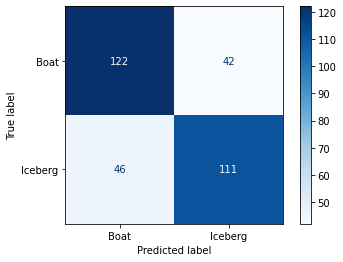

In [ ]:
er = EvaluateAndReport(df, X_train, X_test, y_train, y_test)

param_grid = [{
    'min_samples_leaf': [4],
    'max_features': [None]
}]
er.cv_cv = 3
er.grid_cross_test_report(DecisionTreeClassifier(), param_grid)


In [ ]:
er.y_train

595     0
1181    0
963     1
73      1
666     0
       ..
572     0
248     1
149     0
811     0
1137    0
Name: is_iceberg, Length: 962, dtype: int64

In [ ]:
er.cross_proba_report()

--- Cross Validation with 0.5 Threshold Report ---
 accuracy : 0.649
 f1 : 0.628
 precision : 0.626
 recall : 0.629


In [ ]:
er.cross_proba_report(threshold=0.8)

--- Cross Validation with 0.8 Threshold Report ---
 accuracy : 0.655
 f1 : 0.609
 precision : 0.652
 recall : 0.572


--- Precision Recall Curves ---


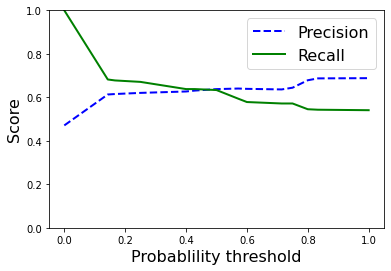

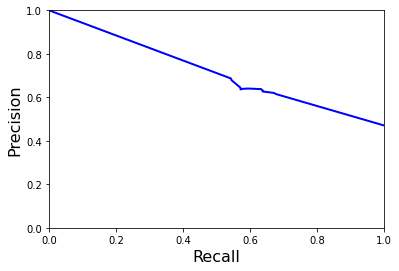

In [ ]:
er.plot_precision_recall()

--- Icebergs predicted as boats ---
Index : 1253


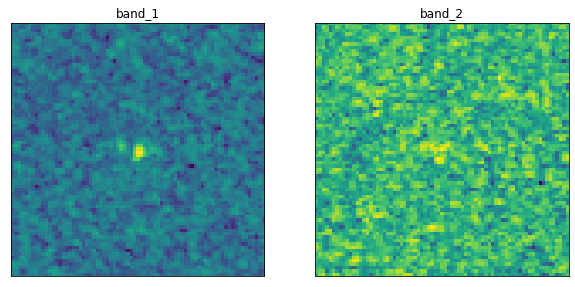

Index : 892


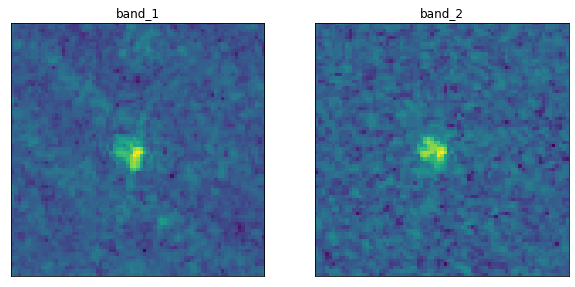

Index : 311


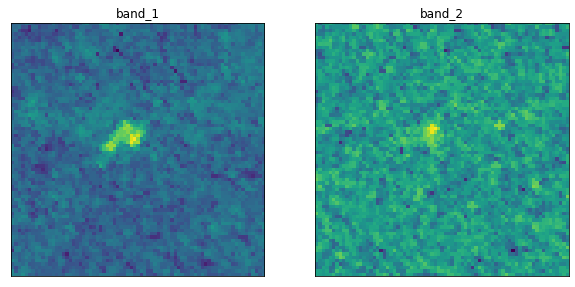

Index : 1048


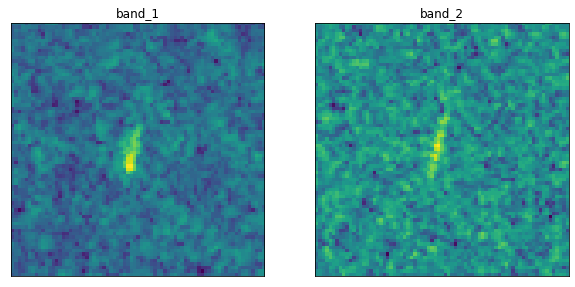

Index : 576


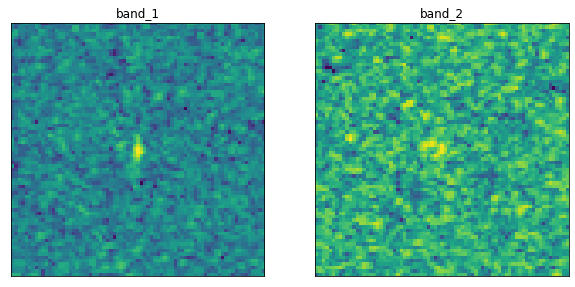

--- Boats predicted as Icebergs ---
Index : 1292


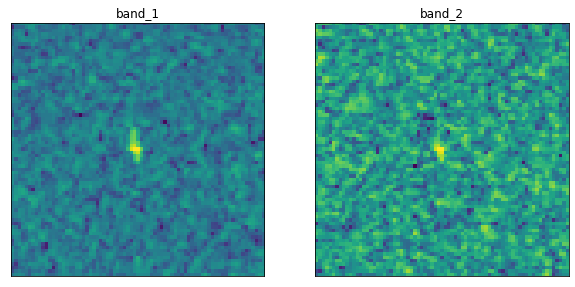

Index : 260


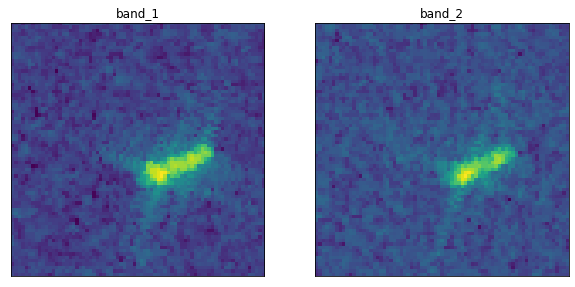

Index : 1103


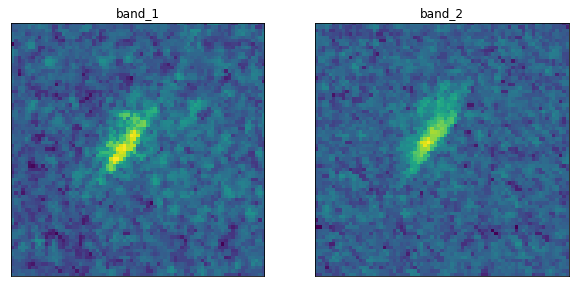

Index : 561


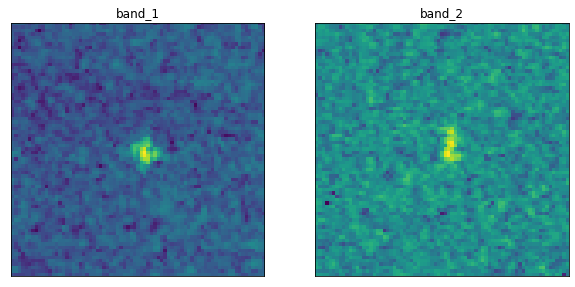

Index : 1373


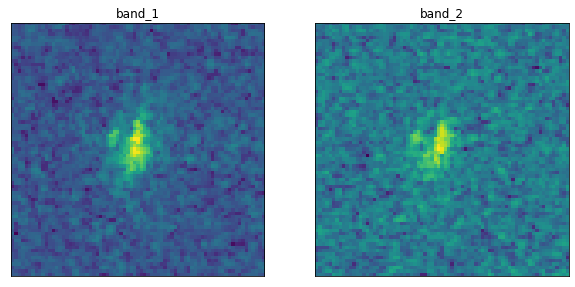

In [ ]:
er.plot_mistakes(nb_samples = 5)

--- Icebergs predicted correctly ---
Index : 209


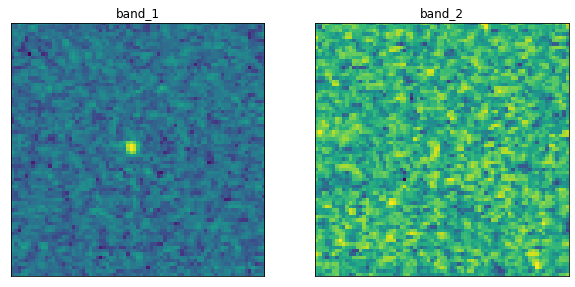

Index : 628


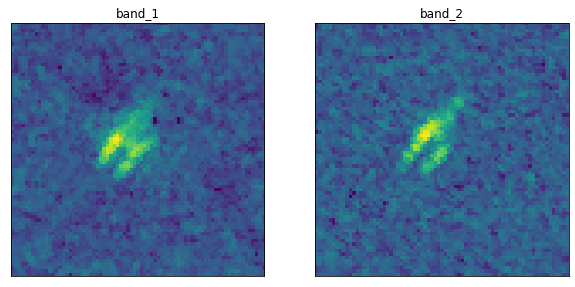

Index : 650


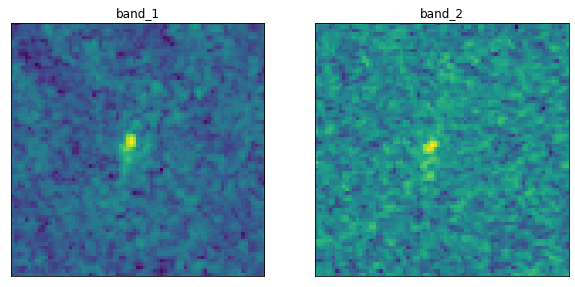

Index : 381


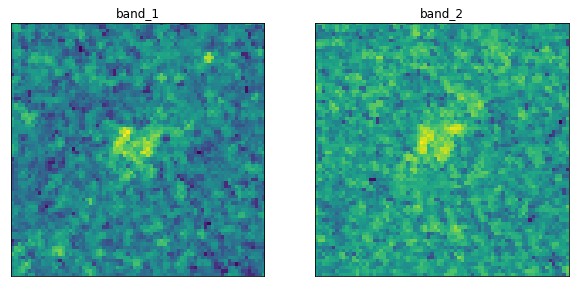

Index : 1029


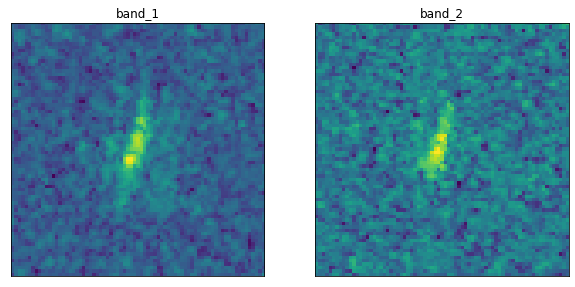

--- Boats predicted correctly ---
Index : 188


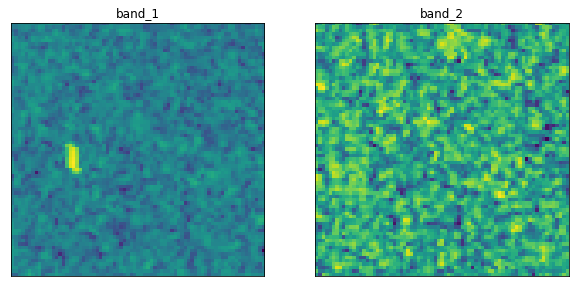

Index : 203


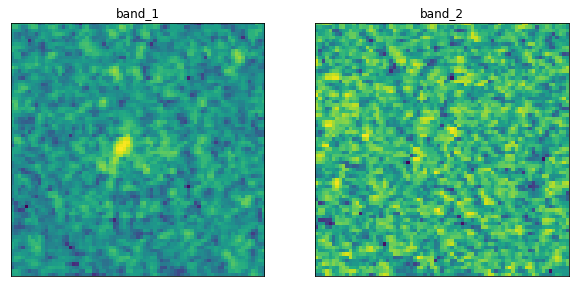

Index : 411


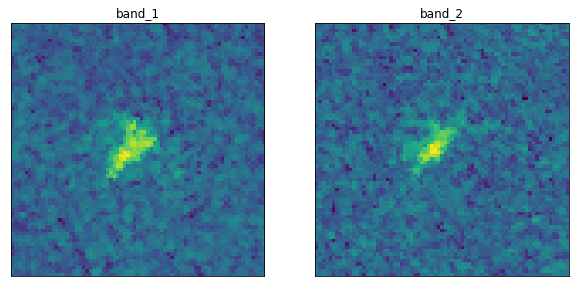

Index : 368


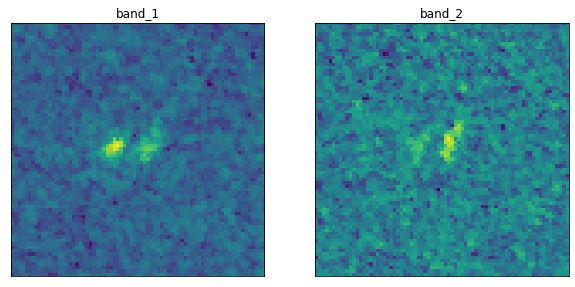

Index : 560


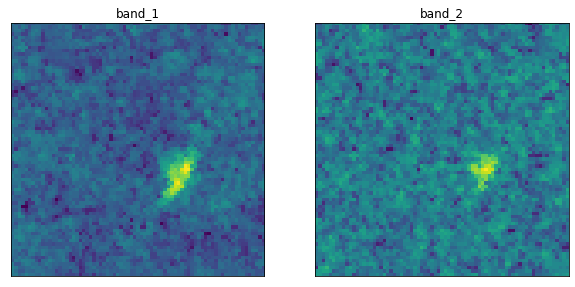

In [ ]:
er.plot_predicted(nb_samples = 5)